In [32]:
# Importujemy niezbędne biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)

Pierwsze 5 wierszy danych:
   treatment  age  blood_pressure      gender blood_test family_history  \
0          1   74       94.113373  non-female   negative          False   
1          1   56       83.337745  non-female   negative          False   
2          0   37       81.759240      female   negative          False   
3          1   54       88.549518      female   negative          False   
4          0   73       82.171555      female   negative            NaN   

    MeasureA     TestB   GeneA  GeneB  GeneC  
0 -11.035690 -0.336843  double      1      0  
1  -3.982345 -0.018734    none      1      1  
2   6.205701  0.147933  double      1      1  
3  -1.827613 -0.338373    none      1      1  
4 -14.637389 -0.369325    none      1      1  


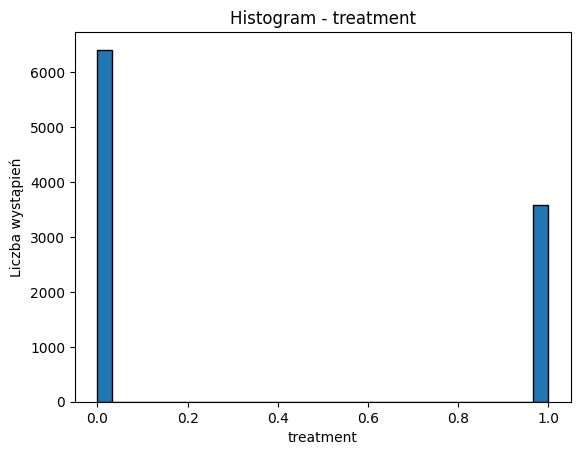

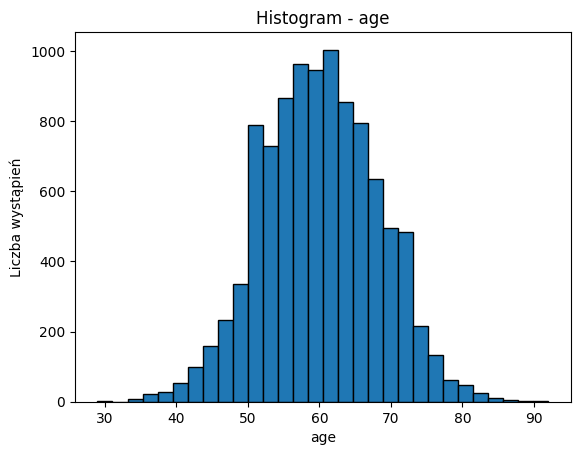

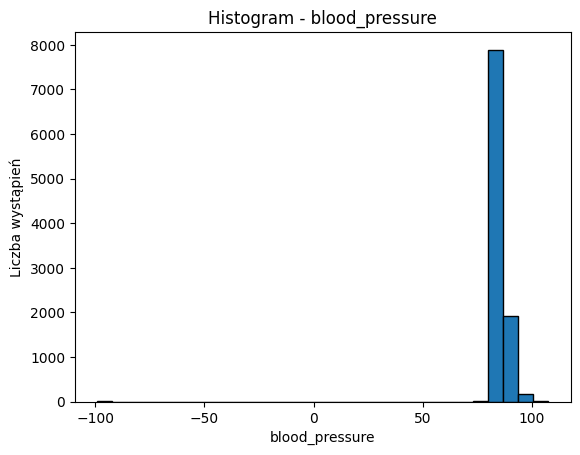

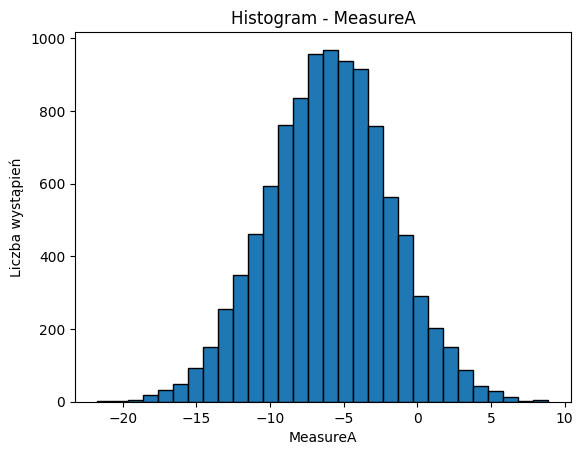

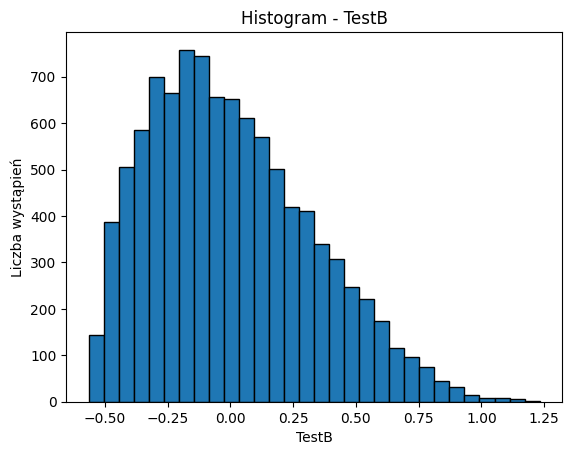

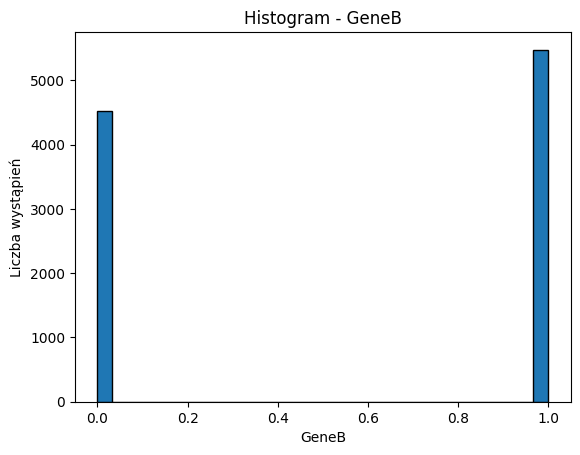

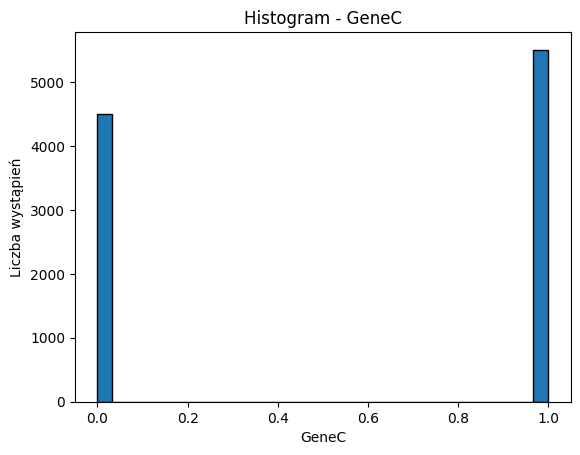

In [23]:
# 1 Wczytanie danych
data = pd.read_csv('data/ps2_available_dataset.csv')
print("Pierwsze 5 wierszy danych:")
print(data.head())

numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    plt.figure()
    plt.hist(data[col].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histogram - {col}')
    plt.xlabel(col)
    plt.ylabel('Liczba wystąpień')
    plt.show()

In [24]:
# 2 Wstępna eksploracja danych
print("\nInformacje o danych:")
print(data.info())
print("\nStatystyki opisowe danych:")
print(data.describe())

# Sprawdzenie brakujących wartości
print("\nLiczba brakujących wartości w poszczególnych kolumnach:")
print(data.isnull().sum())

# W tym przykładzie usuniemy wiersze z brakującymi danymi
data.dropna(inplace=True)

# Sprawdzenie i usuwanie wierszy z ujemnymi wartościami dla blood pressure
if 'blood_pressure' in data.columns:
    # Znalezienie wierszy z ujemną wartością
    neg_bp = data[data['blood_pressure'] < 0]
    if not neg_bp.empty:
        print("\nUsuwanie wierszy z ujemnymi wartościami w kolumnie 'blood pressure':")
        print(neg_bp[['blood_pressure']])
        # Usunięcie wierszy z ujemną wartością
        data = data[data['blood_pressure'] >= 0]
    else:
        print("\nW kolumnie 'blood pressure' nie znaleziono ujemnych wartości.")
else:
    print("\nKolumna 'blood_pressure' nie została znaleziona w danych.")


Informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   treatment       10000 non-null  int64  
 1   age             10000 non-null  int64  
 2   blood_pressure  10000 non-null  float64
 3   gender          10000 non-null  object 
 4   blood_test      10000 non-null  object 
 5   family_history  7068 non-null   object 
 6   MeasureA        10000 non-null  float64
 7   TestB           10000 non-null  float64
 8   GeneA           10000 non-null  object 
 9   GeneB           10000 non-null  int64  
 10  GeneC           10000 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB
None

Statystyki opisowe danych:
          treatment           age  blood_pressure      MeasureA         TestB  \
count  10000.000000  10000.000000    10000.000000  10000.000000  10000.000000   
mean       0.358700     60

In [25]:
# 3. Przygotowanie danych do modelowania
# Zakładamy, że kolumna 'treatment' jest etykietą (target),
# a pozostałe kolumny to cechy (features)

target = 'treatment'
X = data.drop(columns=[target])
y = data[target]

# Podział cech na zmienne numeryczne i kategoryczne
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("\nZmienne numeryczne:", numeric_features)
print("Zmienne kategoryczne:", categorical_features)


Zmienne numeryczne: ['age', 'blood_pressure', 'MeasureA', 'TestB', 'GeneB', 'GeneC']
Zmienne kategoryczne: ['gender', 'blood_test', 'family_history', 'GeneA']


In [26]:
# 4. Podział danych na zbiór treningowy i testowy (zapobiega overfittingowi)
# Używamy stratifikacji, aby zachować proporcje klas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [29]:
# 5. Budowa pipeline’u, preprocesora oraz tuning hiperparametrów
# Preprocesor: skalowanie zmiennych numerycznych oraz kodowanie zmiennych kategorycznych

def create_pipeline(num_features, cat_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('logreg', LogisticRegression(solver='liblinear'))
    ])
    return pipeline

param_grid = {'logreg__C': [0.01, 0.1, 1, 10, 100]}


*** Model z pełnym zestawem cech ***
Najlepsze parametry (pełny zbiór cech): {'logreg__C': 1}

Wyniki modelu z pełnym zestawem cech:
Accuracy: 0.7091295116772823
Precision: 0.6306306306306306
Recall: 0.42168674698795183
F1-score: 0.5054151624548736
ROC AUC: 0.7314152786007415

Drogie cechy znalezione w danych: ['MeasureA', 'TestB', 'GeneA', 'GeneB', 'GeneC']
Najlepsze parametry (bez drogich cech): {'logreg__C': 1}

Wyniki modelu bez drogich cech:
Accuracy: 0.7147912243453645
Precision: 0.6409495548961425
Recall: 0.43373493975903615
F1-score: 0.517365269461078
ROC AUC: 0.723249281278118

Porównanie ROC AUC:
Model pełny: 0.7314152786007415 Model bez drogich cech: 0.723249281278118


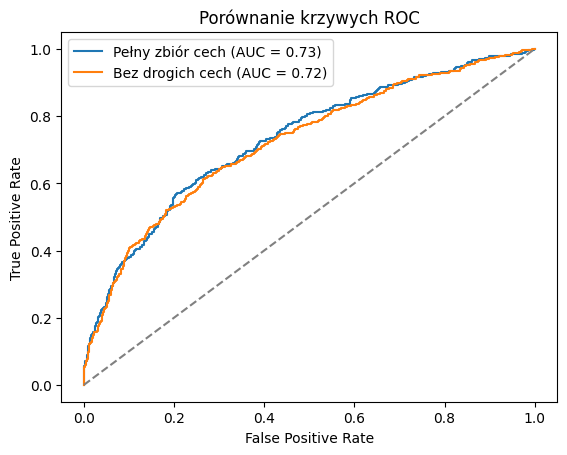


Tworzenie Partial Dependence Plot dla cechy: age


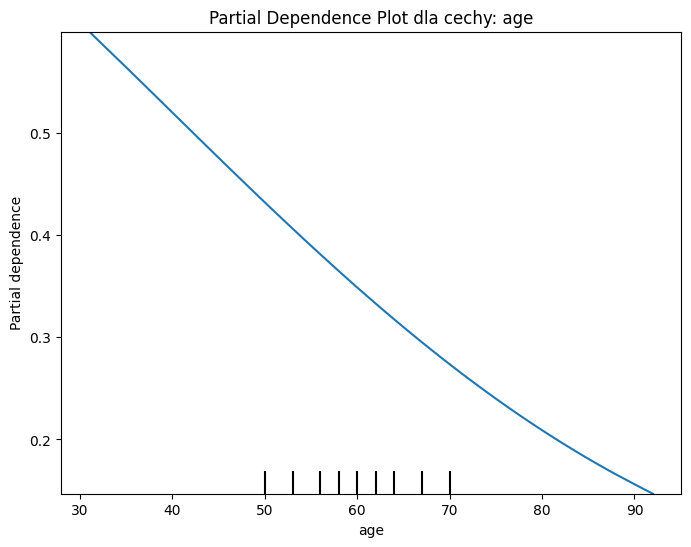

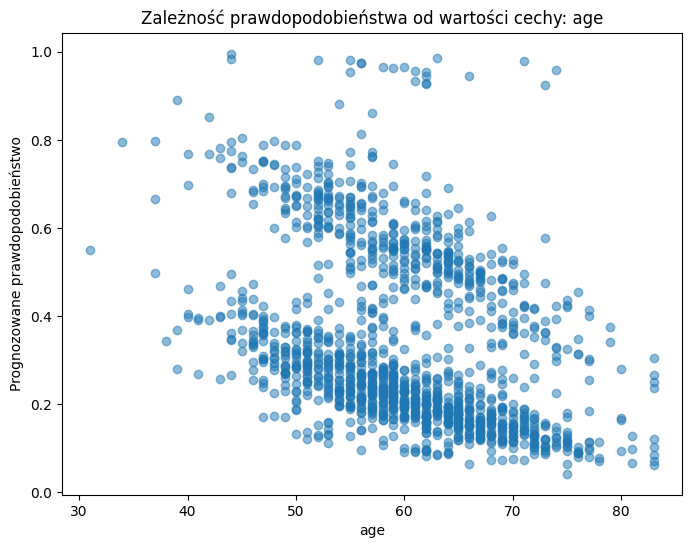

In [ ]:
# ===== Model z pełnym zestawem cech =====
print("\n*** Model z pełnym zestawem cech ***")
# Tworzymy pipeline dla pełnych danych (zmienne numeryczne i kategoryczne pozostają bez zmian)
pipeline_full = create_pipeline(numeric_features, categorical_features)
grid_search_full = GridSearchCV(pipeline_full, param_grid, cv=5, scoring='roc_auc')
grid_search_full.fit(X_train, y_train)
print("Najlepsze parametry (pełny zbiór cech):", grid_search_full.best_params_)
best_model_full = grid_search_full.best_estimator_

# Ewaluacja modelu pełnego
y_pred_full = best_model_full.predict(X_test)
y_proba_full = best_model_full.predict_proba(X_test)[:, 1]
accuracy_full = accuracy_score(y_test, y_pred_full)
precision_full = precision_score(y_test, y_pred_full)
recall_full = recall_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)
roc_auc_full = roc_auc_score(y_test, y_proba_full)

print("\nWyniki modelu z pełnym zestawem cech:")
print("Accuracy:", accuracy_full)
print("Precision:", precision_full)
print("Recall:", recall_full)
print("F1-score:", f1_full)
print("ROC AUC:", roc_auc_full)

# Obliczenie krzywej ROC
fpr_full, tpr_full, _ = roc_curve(y_test, y_proba_full)

# ===== Model bez drogich cech =====
# Lista drogich cech
expensive_features = ['MeasureA', 'TestB', 'GeneA', 'GeneB', 'GeneC']
# Sprawdzamy, które z nich istnieją w zbiorze
existing_expensive = [feat for feat in expensive_features if feat in X.columns]
if existing_expensive:
    print("\nDrogie cechy znalezione w danych:", existing_expensive)
    # Tworzymy zredukowany zbiór cech, usuwając drogie cechy
    X_reduced = X.drop(columns=existing_expensive)
    
    # Ustalamy nowe listy zmiennych numerycznych oraz kategorycznych
    numeric_features_red = X_reduced.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features_red = X_reduced.select_dtypes(include=['object']).columns.tolist()
    
    # Podział danych: tutaj używamy tych samych indeksów z wcześniejszego podziału
    X_train_red = X_train.drop(columns=existing_expensive)
    X_test_red = X_test.drop(columns=existing_expensive)
    
    # Tworzymy pipeline dla zbioru bez drogich cech
    pipeline_red = create_pipeline(numeric_features_red, categorical_features_red)
    grid_search_red = GridSearchCV(pipeline_red, param_grid, cv=5, scoring='roc_auc')
    grid_search_red.fit(X_train_red, y_train)
    print("Najlepsze parametry (bez drogich cech):", grid_search_red.best_params_)
    best_model_red = grid_search_red.best_estimator_
    
    # Ewaluacja modelu bez drogich cech
    y_pred_red = best_model_red.predict(X_test_red)
    y_proba_red = best_model_red.predict_proba(X_test_red)[:, 1]
    accuracy_red = accuracy_score(y_test, y_pred_red)
    precision_red = precision_score(y_test, y_pred_red)
    recall_red = recall_score(y_test, y_pred_red)
    f1_red = f1_score(y_test, y_pred_red)
    roc_auc_red = roc_auc_score(y_test, y_proba_red)
    
    print("\nWyniki modelu bez drogich cech:")
    print("Accuracy:", accuracy_red)
    print("Precision:", precision_red)
    print("Recall:", recall_red)
    print("F1-score:", f1_red)
    print("ROC AUC:", roc_auc_red)
    
    # Obliczenie krzywej ROC dla modelu bez drogich cech
    fpr_red, tpr_red, _ = roc_curve(y_test, y_proba_red)
    
    # Porównanie wyników
    print("\nPorównanie ROC AUC:")
    print("Model pełny:", roc_auc_full, "Model bez drogich cech:", roc_auc_red)
else:
    print("\nBrak drogich cech (MeasureA, TestB, GeneA, GeneB, GeneC) w danych.")
    best_model_red = None  # Nie wykonujemy porównania

# ===== Wizualizacja krzywej ROC obu modeli na jednym wykresie =====
plt.figure()
plt.plot(fpr_full, tpr_full, label=f'Pełny zbiór cech (AUC = {roc_auc_full:.2f})')
if best_model_red is not None:
    plt.plot(fpr_red, tpr_red, label=f'Bez drogich cech (AUC = {roc_auc_red:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Porównanie krzywych ROC')
plt.legend()
plt.show()

# Iterujemy przez każdą zmienną numeryczną
for feature in numeric_features:
    print(f"\nGenerowanie wykresów dla cechy: {feature}")

    # ----- Partial Dependence Plot (PDP) -----
    # PDP pokazuje, jak zmiana wartości danej cechy wpływa na prognozowaną wartość (średnio, po uśrednieniu wpływu pozostałych cech).
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(best_model_full, X_train, [feature], ax=ax)
    ax.set_title(f'Partial Dependence Plot dla cechy: {feature}')
    plt.show()

    # ----- Wykres rozrzutu (scatter plot) -----
    # Wykres rozrzutu pokazuje, jak dla każdego wiersza z zestawu testowego (X_test) wartość wybranej cechy koreluje z prognozowanym prawdopodobieństwem klasy pozytywnej.
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[feature], y_proba_full, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Prognozowane prawdopodobieństwo klasy pozytywnej')
    plt.title(f'Zależność wartości cechy {feature} od prognozowanego prawdopodobieństwa')
    plt.show()